Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.set_figure_params(dpi=100, dpi_save = 300, color_map = 'viridis')
sc.settings.verbosity = 1
sc.logging.print_header()
plt.rcParams['pdf.fonttype'] = 42
sc.settings.figdir = 'figures'

scanpy==1.8.2 anndata==0.7.5 umap==0.5.2 numpy==1.20.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.9.1 pynndescent==0.5.6


### Read pre-processed data

In [ ]:
adata = sc.read('data/core_GBmap.h5ad')
adata

AnnData object with n_obs × n_vars = 431535 × 36498
    obs: 'author', 'patient', 'celltype_malignant', 'celltype_major', 'celltype_minor', 'gender', 'location', 'EGFR', 'platform', 'method', 'age', 'MET', 'p53', 'TERT', 'ATRX', 'PTEN', 'MGMT', 'sample', 'celltype_original', 'KI_67', 'region', 'Tissue', 'chr1p19q', 'stage', 'Verhaak_classification', 'PDGFR', 'gs_prediction', 'gs_prediction_main', 'gs_prediction_detailed', 'cnv_full_geneset', 'cnv_filtered_geneset', 'celltype_assigned'
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key="author",
    layer="counts",
    subset=True)

/hpc/pmc_stunnenberg/cruiz/miniconda3/envs/scarches/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
source_adata = adata[adata.obs['method'].isin(['cell'])].copy() # cells used in the core GBmap

In [ ]:
# integrate datasets that were generated using single-nuclei RNA seq
target_adata_nuclei = adata[adata.obs['method'].isin(['nuclei'])].copy()
target_adata_nuclei.obs['celltype_final'] = target_adata_nuclei.obs['celltype_original']

In [ ]:
target_adata_cell = sc.read('data/query_GB_studies.h5ad')

In [ ]:
target_adata_cell.obs['celltype_final'] = target_adata_cell.obs['celltype']

In [ ]:
target_adata_cell_2 = sc.read('data/query_GB_studies_addition.h5ad')

In [ ]:
target_adata_cell_2.obs['celltype_final'] = np.nan # this studies did not provide original annotation

In [ ]:
target_adata = target_adata_cell.concatenate(target_adata_nuclei, target_adata_cell_2)

In [ ]:
target_adata.layers["counts"] = target_adata.X.copy()

## Mapping New GBM datasets

### Load reference model

In [ ]:
# run 'Read pre-processed data'
ref_path = 'scarches_models/zenodo_model/'
vae = sca.models.SCANVI.load(ref_path, source_adata)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 338564 cells, 5000 vars, 17       
         batches, 20 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


### Perform surgery on reference model and train on query dataset without cell type labels

In [ ]:
condition_key = 'author'
cell_type_key = 'celltype_final'

vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [ ]:
# add this to avoid error https://github.com/theislab/scarches/issues/35

target_adata.obs['orig_cell_types'] = target_adata.obs[cell_type_key].copy()
target_adata.obs[cell_type_key] = vae.unlabeled_category_

In [ ]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
    inplace_subset_query_vars = True # to reorder vars and train model properly
    # if not you'll get a warning
    #var_names for adata passed in does not match var_names of adata used to train the  
#           model. For valid results, the vars need to be the same and in the same order as the
#           adata used to train the model.  
    # https://github.com/YosefLab/scvi-tools/issues/849
)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 797113 cells, 5000 vars, 27       
         batches, 21 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


In [ ]:
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  797113


In [ ]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 10 epochs.                                        
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  69%|██████▊   | 343/500 [24:22:24<11:05:20, 254.27s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  69%|██████▊   | 343/500 [24:26:40<11:11:20, 256.56s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Traini

In [ ]:
query_latent = sc.AnnData(model.get_latent_representation())

In [ ]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)

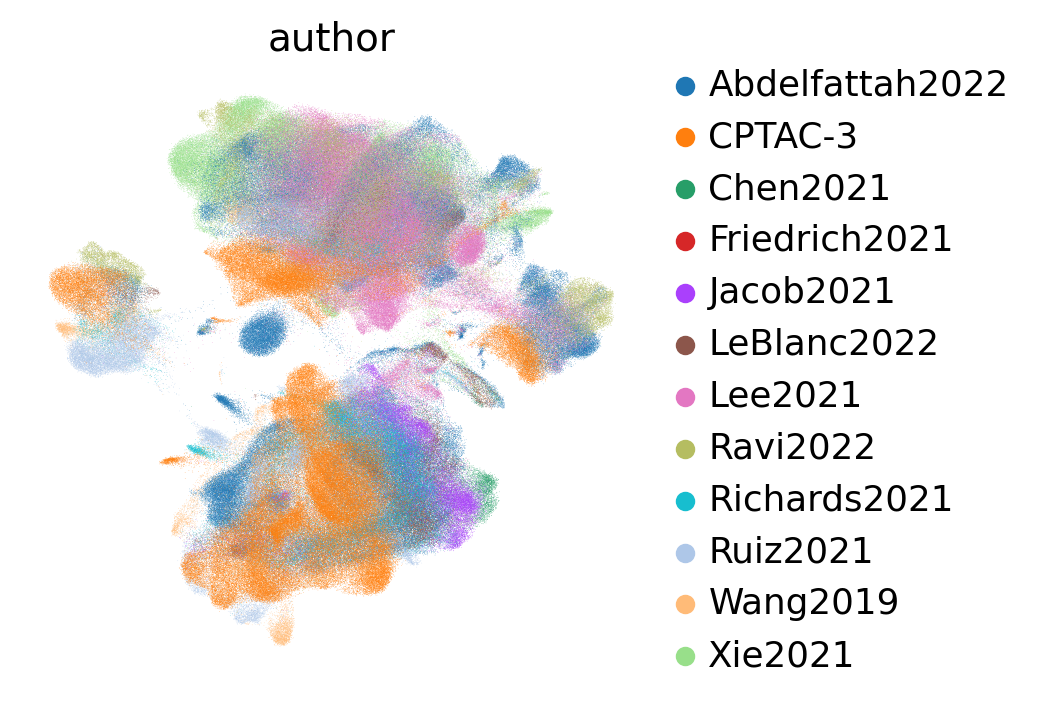

In [ ]:
query_latent.obs["author"] = target_adata.obs["author"].tolist()
sc.pl.umap(query_latent,
           color=['author'],
           frameon=False,
           wspace=0.6,
           )

... storing 'predictions' as categorical


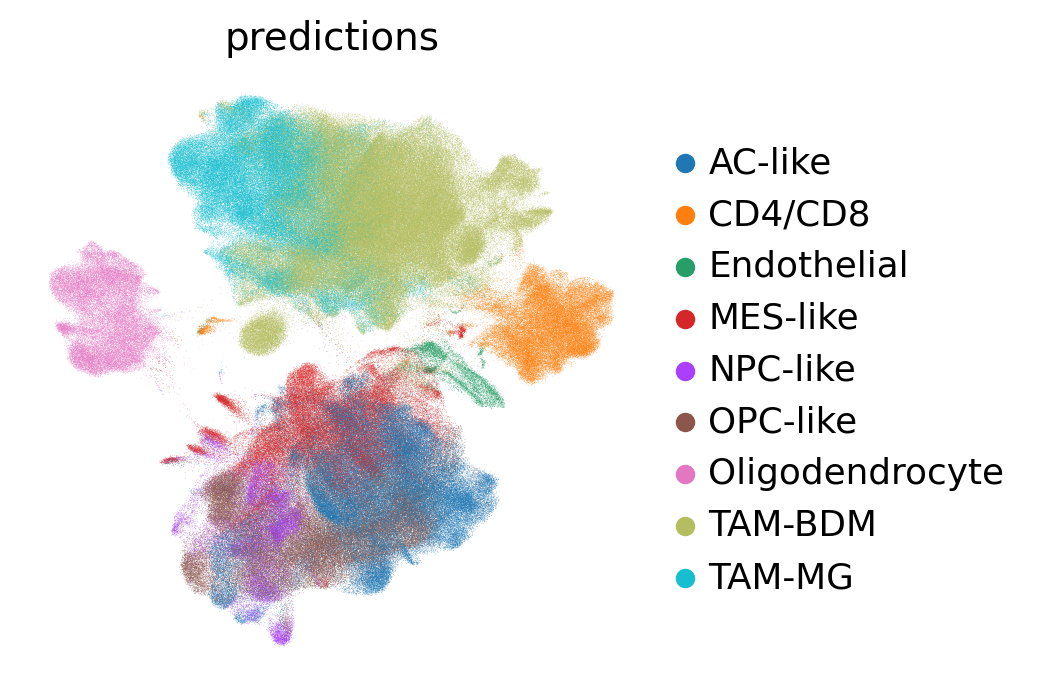

In [ ]:
query_latent.obs['predictions'] = model.predict()
sc.pl.umap(query_latent,
           color=['predictions'],
           frameon=False,
           wspace=0.6,
           )

... storing 'method' as categorical


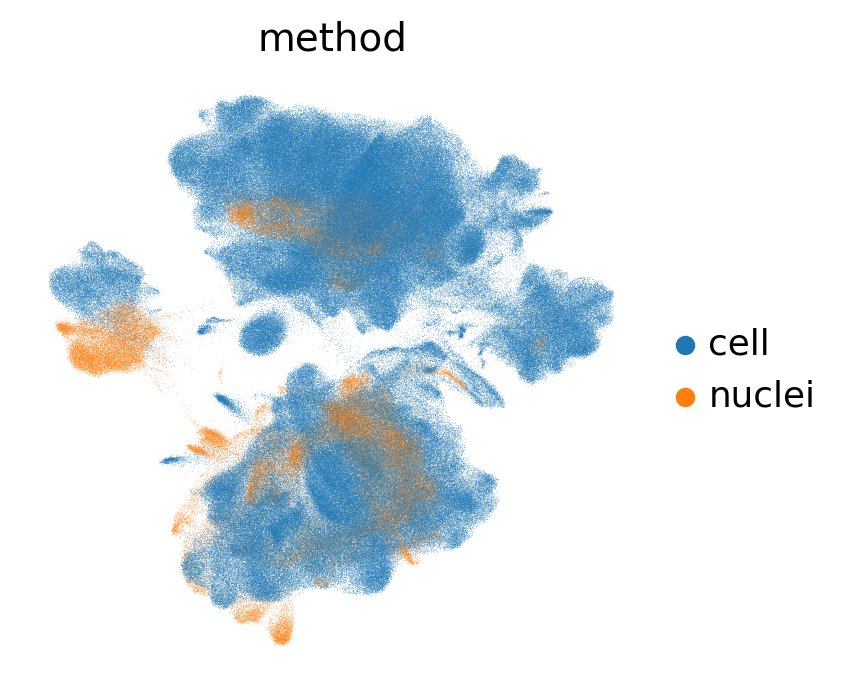

In [ ]:
query_latent.obs["method"] = target_adata.obs["method"].tolist()
sc.pl.umap(query_latent,
           color=['method'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
query_latent.write_h5ad('data/clustering_query_GB_datasets.h5ad')

In [ ]:
target_adata.write('data/query_GB_datasets.h5ad')

### Get latent representation of reference + query dataset and compute UMAP

In [ ]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")

In [ ]:
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1135677 cells, 5000 vars, 27      
         batches, 21 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


In [ ]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

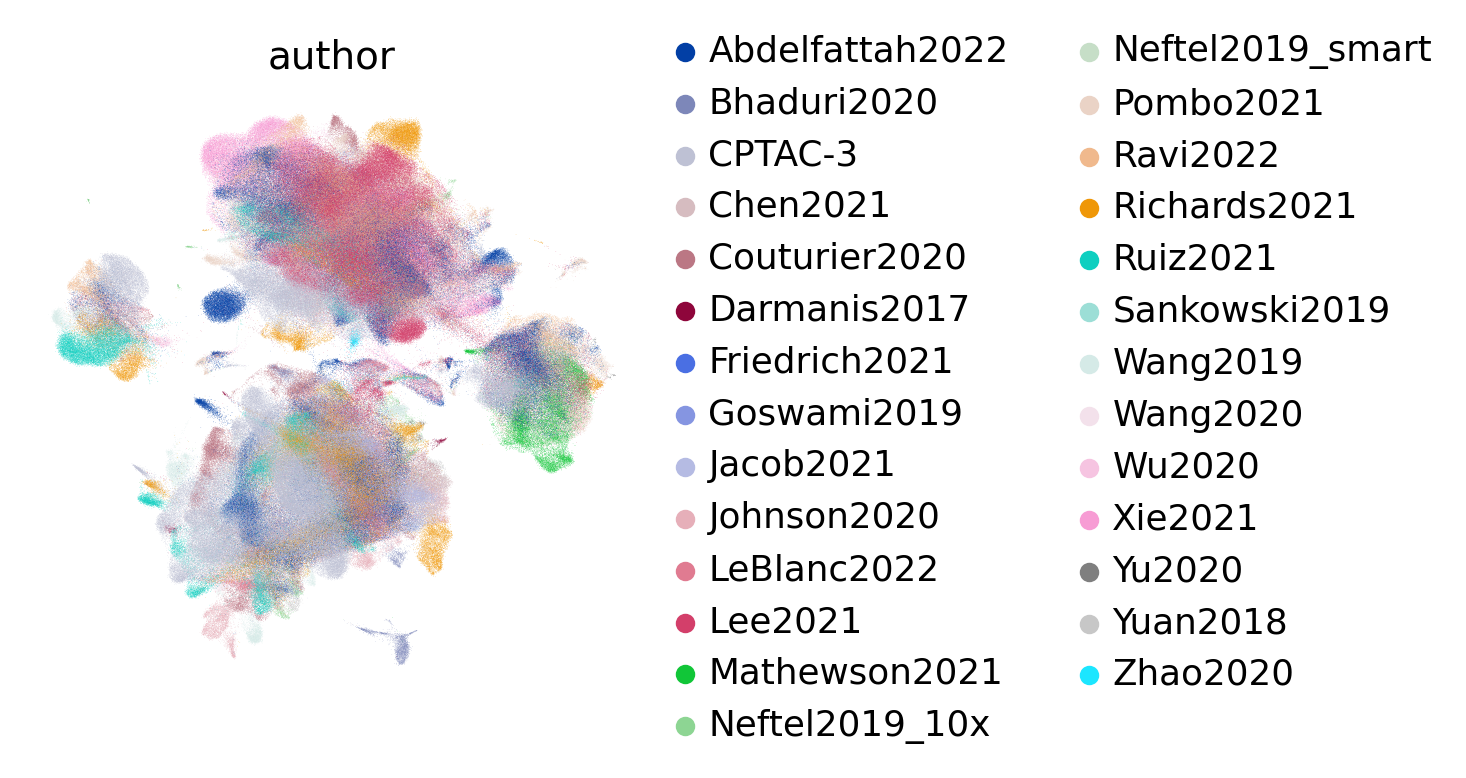

In [ ]:
full_latent.obs["author"] = adata_full.obs["author"].tolist()
sc.pl.umap(full_latent,
           color=['author'],
           frameon=False,
           wspace=0.6,
           )

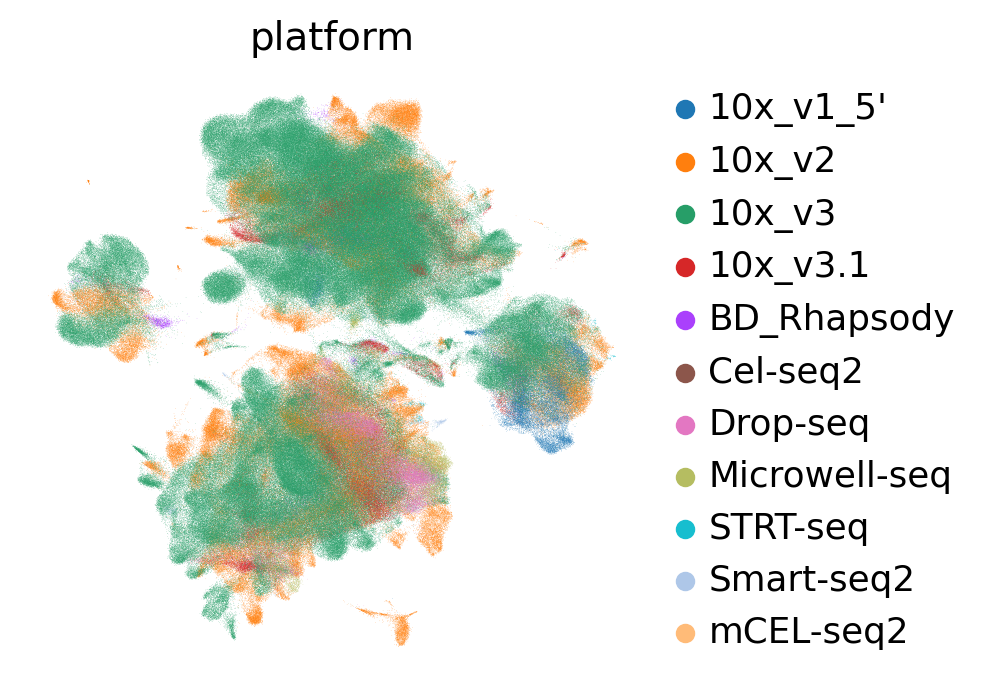

In [ ]:
full_latent.obs["platform"] = adata_full.obs["platform"].tolist()
sc.pl.umap(full_latent,
           color=['platform'],
           frameon=False,
           wspace=0.6,
           )

... storing 'method' as categorical


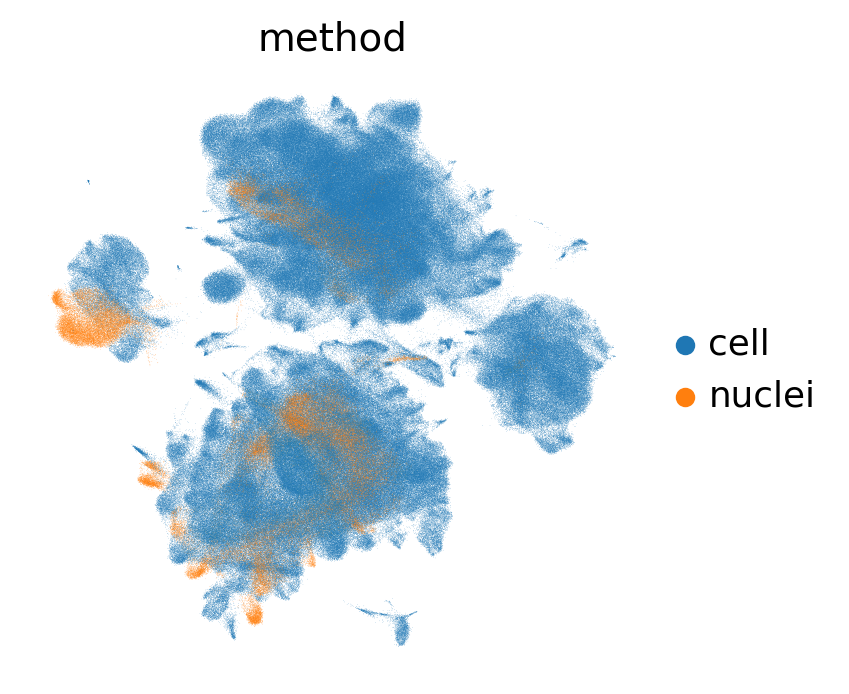

In [ ]:
full_latent.obs["method"] = adata_full.obs["method"].tolist()
sc.pl.umap(full_latent,
           color=['method'],
           frameon=False,
           wspace=0.6,
           )

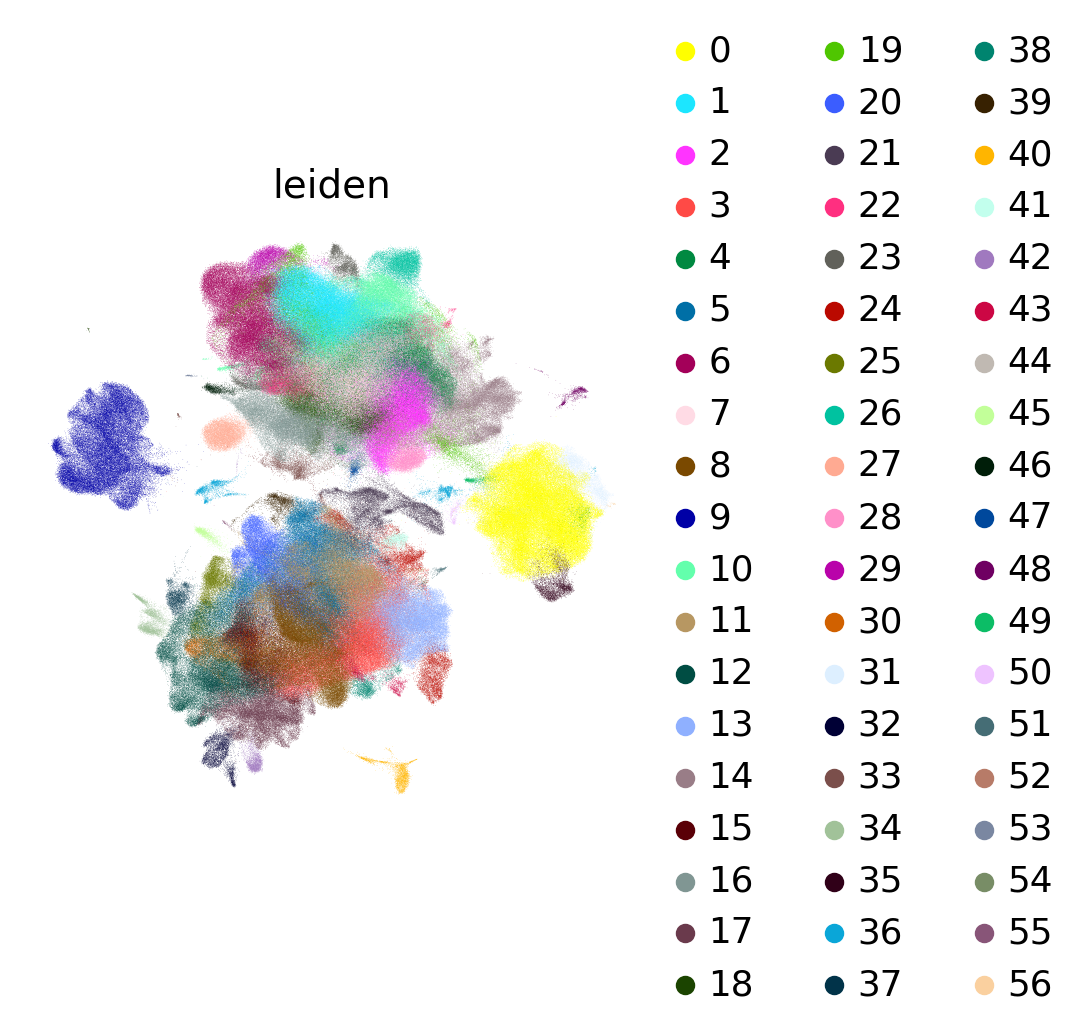

In [ ]:
sc.pl.umap(full_latent,
           color=['leiden'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
adata_full.write_h5ad('data/extended_GBmap.h5ad')
full_latent.write_h5ad('data/latent_extended_GBmap.h5ad')